<img src="./logo_UTN.svg" align="right" width="150" /> 

#### Procesamiento Digital de Señales

# Tarea Semanal Nº8
#### Gisela Farace

## Consigna

#### Estimación espectral. Método de Welch <br>
 
Evalue el siguiente estimador de frecuencia de una senoidal contaminada por ruido incorrelado. <br>

Para una señal $x(k)=a_{0}.sen(\Omega_{1}.k)+n(k)$<br>

siendo

$\Omega_{1}=\Omega_{0}+f_{r}.\frac{2\pi}{N}$

$\Omega_{0}=\frac{\pi}{2}$

y las variables aleatorias definidas por

$f_{r}\sim U(-\frac{1}{2},\frac{1}{2})$

$n\sim N(0,\sigma^2)$

Evalúe el siguiente estimador de $\Omega_{1}$

$\hat{\Omega_{1}}^{W}=arg_{f}max{\hat{P_{W}}}$

basado en el periodograma de Welch evaluado en 3). Del mismo modo, evalúe otro estimador de la PSD para crear otro estimador de $\Omega_{1}$

$\hat{\Omega_{1}}^{X}=arg_{f}max{\hat{P_{X}}}$

Considere 200 realizaciones de 1000 muestras para cada experimento. Cada realización debe tener un SNR tal que el pico de la senoidal esté 3 y 10 db por encima del piso de ruido impuesto por $n(k)$.

## Código

#### Importación de librerias

In [2]:
# Importación de módulos para Jupyter

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.signal.windows as wind
from spectrum import pcorrelogram as BlackmanTukey

# Para la tabla
from pandas import DataFrame
from IPython.display import HTML

#Presentación de los gŕaficos
mpl.rcParams['figure.figsize'] = (17,5)
fig_sz_x = 14
fig_sz_y = 13
fig_dpi = 80 # dpi

fig_font_family = 'Ubuntu'
fig_font_size = 16

plt.rcParams.update({'font.size':fig_font_size})
plt.rcParams.update({'font.family':fig_font_family})

### 1) Compruebe experimentalmente las propiedades de sesgo y varianza del periodograma.

In [3]:
fs = 1000 # frecuencia de muestreo (Hz)

N = np.array([10, 50, 100, 250, 500, 1000, 5000], dtype=float)
R = 200 # realizaciones

sesgo = np.zeros(len(N))
varianza = np.zeros(len(N))
sigma = 2

for i in range(0,len(N)):
    K = int(N[i])
    frec = np.fft.fftfreq(K, d=1/fs)
    x = np.random.normal(0, np.sqrt(sigma), size=(K,R)) # ruido normalmente distribuido
    fft_x = np.fft.fft(x, K, axis = 0)
    Per_x = (1/K)*(np.abs(fft_x)**2)
    E_x = Per_x.mean() # media muestral  
    sesgo[i] = sigma - E_x
    varianza[i] = Per_x.var()

datos = [ 
          [sesgo[0], varianza[0]],
          [sesgo[1], varianza[1]], 
          [sesgo[2], varianza[2]],
          [sesgo[3], varianza[3]],
          [sesgo[4], varianza[4]], 
          [sesgo[5], varianza[5]], 
          [sesgo[6], varianza[6]],
        ]
df = DataFrame(datos, columns=['$s_P$', '$v_P$'], index=N)
HTML(df.to_html())

,$s_P$,$v_P$
10.0,0.048621,4.834762
50.0,-0.042381,4.322856
100.0,-0.006670,4.168221
250.0,0.009564,3.943275
500.0,0.008796,3.972367
1000.0,0.005352,4.016289
5000.0,-0.004718,4.023115


Se puede observar que la varianza no tiende a cero, por lo tanto el periodograma es inconcistente del espectro de potencia. El periodograma tiene una varianza constante igual a $\sigma^4$, en este caso es 4 por usar $\sigma^2=2$, lo cual no depende de N. Además, es asintóticamente insesgado debido a que a medida que N tiende a infinito, la ventana de Barlett converge a un impulso.


### 4) Evalue el siguiente estimador de frecuencia de una senoidal contaminada por ruido incorrelado.

Text(0.5, 0.98, 'Periodograma')

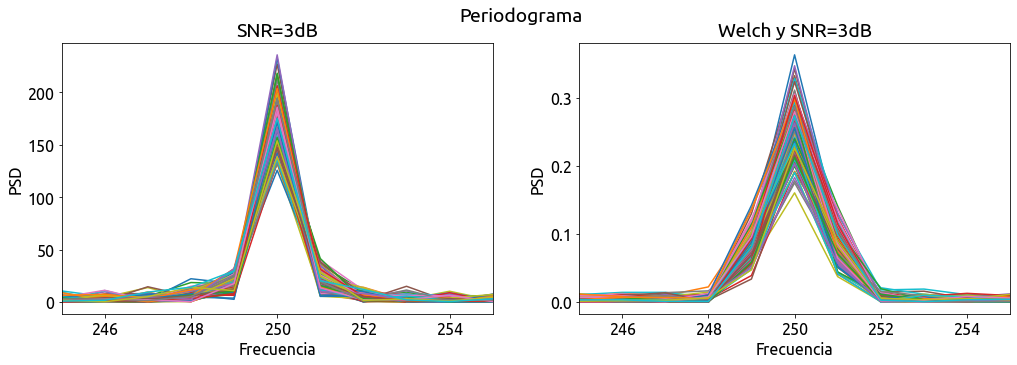

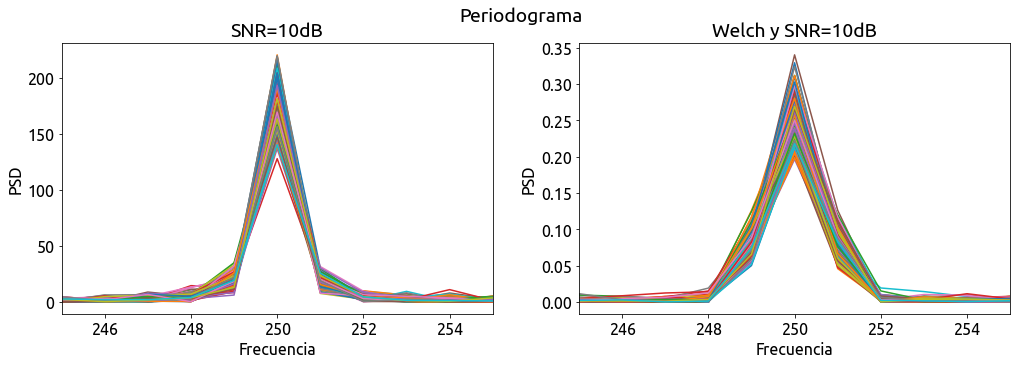

In [4]:
#Senoidal
#x(k)=a1⋅sen(Ω1⋅k)+n(k)
#Ω1=Ω0+(fr.2π)/N
#Ω0 = pi/2

N = 1000  # cantidad de muestras
fs = 1000 # frecuencia de muestreo (Hz)
R = 200 # realizaciones

SNR = np.array([3, 10], dtype=float) #En dB
# SNR = 10.log(Ps/Pn)
# Pn = Ps/[10^(SNR/10)]
# Ps = A^2/2 --> A = sqrt(Ps*2)
pot_sen = 1 #potencia unitaria
a1 = np.sqrt(pot_sen*2) # amplitud senoidal
pot_ruido = pot_sen/(10**(SNR/20))

ts = 1/fs # tiempo de muestreo (Hz)
df = fs/N # resolución espectral
tt = np.linspace(0, (N-1), N) * (1/fs)

frec = np.linspace(0, (N-1), N)*df

# Variables aleatorias
fr = np.random.uniform(low=-1/2, high=1/2, size=(N,R)) # distribución uniforme
n_3db = np.random.normal(0, np.sqrt(pot_ruido[0]), size=(N,R)) # ruido con SNR 3dB
n_10db = np.random.normal(0, np.sqrt(pot_ruido[1]), size=(N,R)) # ruido con SNR 10dB

ff = (np.pi/2 + fr*(2*np.pi/N))*(fs/(2*np.pi))
x = a1*np.sin(2*np.pi*ff*tt.reshape(N,1))

######### Para SNR=3dB #########
x1 = x + n_3db
#Periodograma
fft_x1 = np.fft.fft(x1, N, axis = 0)
Per_x1 = (1/N)*(np.abs(fft_x1)**2)
#Welch
fw_x1, Pw_x1 = sig.welch(x1, fs, nperseg=fs, axis=0)
fig1, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(frec,Per_x1)
ax1.set_xlim(245,255)
ax1.set_title('SNR={:1.0f}dB'.format(SNR[0]))
ax1.set(xlabel='Frecuencia', ylabel='PSD')
ax2.plot(fw_x1,Pw_x1)
ax2.set_xlim(245,255)
ax2.set_title('Welch y SNR={:1.0f}dB'.format(SNR[0]))
ax2.set(xlabel='Frecuencia', ylabel='PSD')
fig1.suptitle('Periodograma')

######### Para SNR=10dB #########
x2 = x + n_10db
#Periodograma
fft_x2 = np.fft.fft(x2, N, axis = 0)
Per_x2 = (1/N)*(np.abs(fft_x2)**2)
#Welch
fw_x2, Pw_x2 = sig.welch(x2, fs, nperseg=fs, axis=0)
fig2, (ax3, ax4) = plt.subplots(1, 2)
ax3.plot(frec,Per_x2)
ax3.set_xlim(245,255)
ax3.set_title('SNR={:1.0f}dB'.format(SNR[1]))
ax3.set(xlabel='Frecuencia', ylabel='PSD')
ax4.plot(fw_x2,Pw_x2)
ax4.set_xlim(245,255)
ax4.set_title('Welch y SNR={:1.0f}dB'.format(SNR[1]))
ax4.set(xlabel='Frecuencia', ylabel='PSD')
fig2.suptitle('Periodograma')

### Con padding

(-9.0, 1.0)

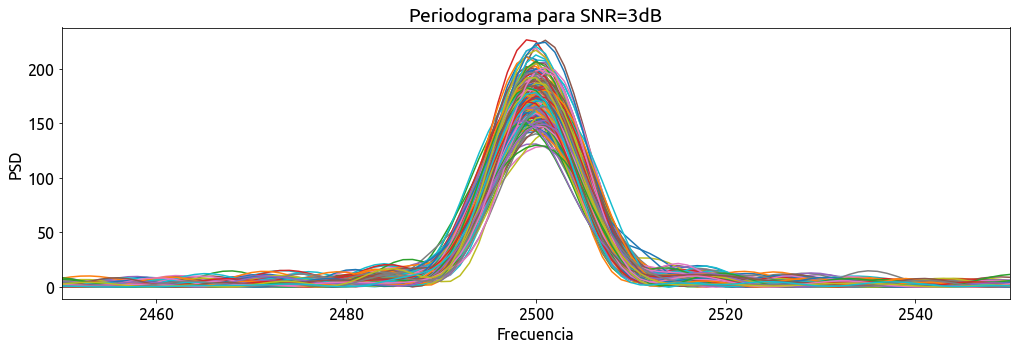

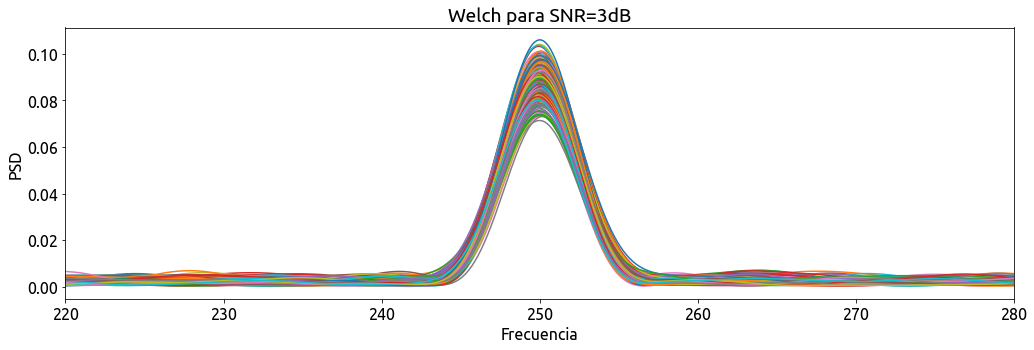

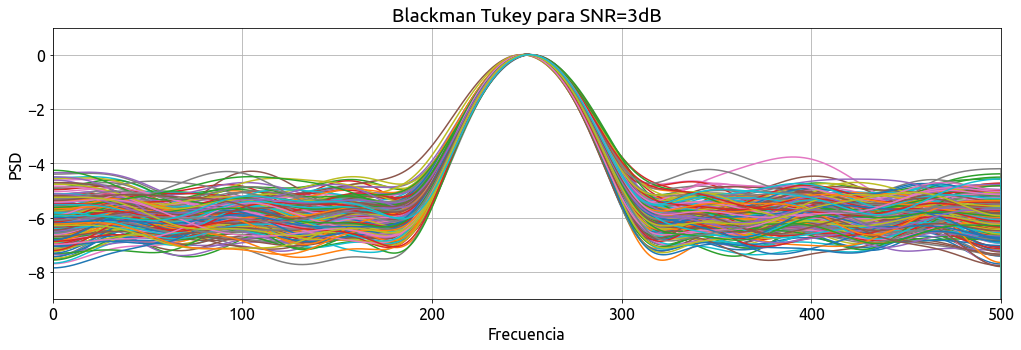

In [5]:
## CON PADDING ##
#Senoidal
#x(k)=a1⋅sen(Ω1⋅k)+n(k)
#Ω1=Ω0+(fr.2π)/N
#Ω0 = pi/2

N = 1000  # cantidad de muestras
fs = 1000 # frecuencia de muestreo (Hz)
R = 200 # realizaciones
Npad = N*10

SNR = np.array([3, 10], dtype=float) #En dB
# SNR = 10.log(Ps/Pn)
# Pn = Ps/[10^(SNR/10)]
# Ps = A^2/2 --> A = sqrt(Ps*2)
pot_sen = 1 #potencia unitaria
a1 = np.sqrt(pot_sen*2) # amplitud senoidal
pot_ruido = pot_sen/(10**(SNR/20))

ts = 1/fs # tiempo de muestreo (Hz)
df = fs/N # resolución espectral
tt = np.linspace(0, (N-1), N) * (1/fs)

frec = np.linspace(0, (N-1), N)*df
frec_p = np.linspace(0, (Npad-1), Npad)*fs/N

# Variables aleatorias
fr = np.random.uniform(low=-1/2, high=1/2, size=(N,R)) # distribución uniforme
n_3db = np.random.normal(0, np.sqrt(pot_ruido[0]), size=(N,R)) # ruido con SNR 3dB
n_10db = np.random.normal(0, np.sqrt(pot_ruido[1]), size=(N,R)) # ruido con SNR 10dB

ff = (np.pi/2 + fr*(2*np.pi/N))*(fs/(2*np.pi))
x = a1*np.sin(2*np.pi*ff*tt.reshape(N,1))

#################### Para SNR=3dB ####################
x1 = x + n_3db
#----------------- Periodograma -----------------#
fft_x1_p = np.fft.fft(x1, axis = 0, n=Npad)
x1_per = (1/N)*(np.abs(fft_x1_p)**2)

plt.figure(1)
plt.plot(frec_p,x1_per)
plt.title('Periodograma para SNR={:1.0f}dB'.format(SNR[0]))
plt.xlabel('Frecuencia')
plt.ylabel('PSD')
plt.xlim(2450,2550)

#----------------- Welch -----------------#
fw_x1_w, x1_welch = sig.welch(x1, fs, nfft=Npad, axis=0)
x1_picos_w = np.argmax(x1_welch, axis=0)/(Npad/N)

plt.figure(2)
plt.plot(fw_x1_w,x1_welch)
plt.title('Welch para SNR={:1.0f}dB'.format(SNR[0]))
plt.xlabel('Frecuencia')
plt.ylabel('PSD')
plt.xlim(220,280)

#----------------- Blackman Tukey -----------------#
# la funcion del spectrum no tiene para indicarle axis
x1_picos_b = np.zeros(R)
x1_black = np.zeros(R)
plt.figure(3)
for i in range(0,R):
    x1black = BlackmanTukey(x1[:,i],lag=15, NFFT=Npad, sampling=fs)
    x1_black = x1black.psd
    x1_picos_b[i] = np.argmax(x1_black, axis=0)/(Npad/N)
    x1black.plot(norm=True)
plt.title('Blackman Tukey para SNR={:1.0f}dB'.format(SNR[0]))
plt.xlabel('Frecuencia')
plt.ylabel('PSD')
plt.ylim(-9,1)

(-11.0, 1.0)

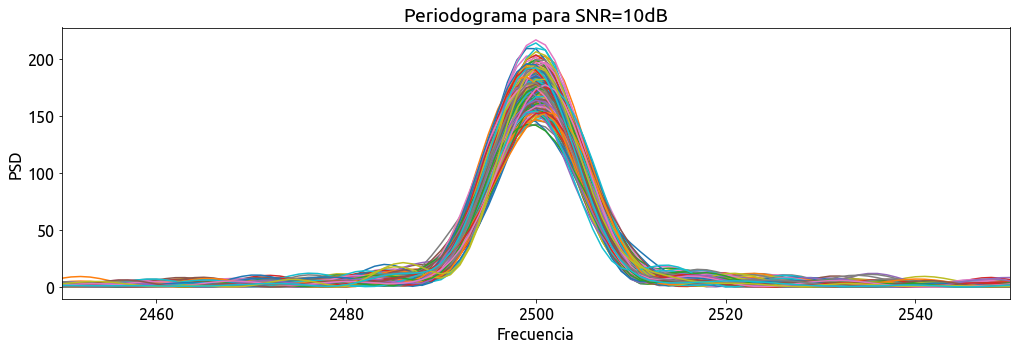

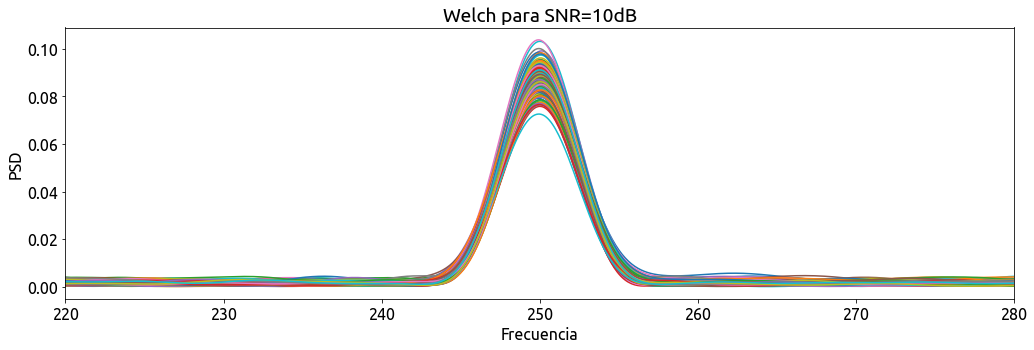

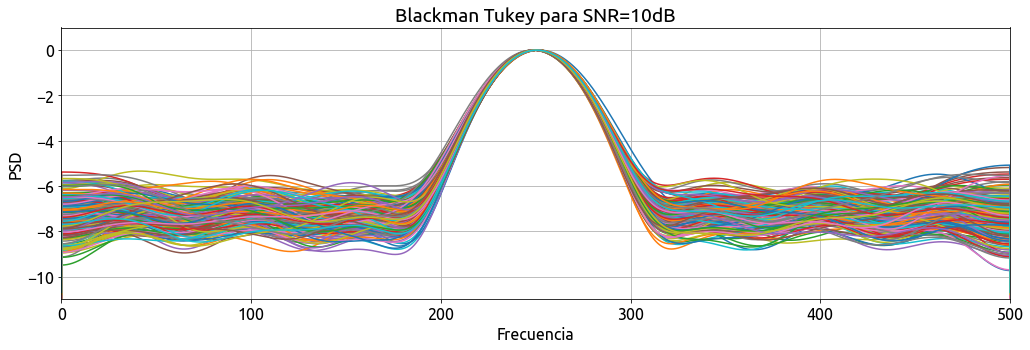

In [6]:
#################### Para SNR=10dB ####################
x2 = x + n_10db
#----------------- Periodograma -----------------#
fft_x2_p = np.fft.fft(x2, axis = 0, n=Npad)
x2_per = (1/N)*(np.abs(fft_x2_p)**2)

plt.figure(1)
plt.plot(frec_p,x2_per)
plt.title('Periodograma para SNR={:1.0f}dB'.format(SNR[1]))
plt.xlabel('Frecuencia')
plt.ylabel('PSD')
plt.xlim(2450,2550)

#----------------- Welch -----------------#
fw_x2_w, x2_welch = sig.welch(x2, fs, nfft=Npad, axis=0)
x2_picos_w = np.argmax(x2_welch, axis=0)/(Npad/N)

plt.figure(2)
plt.plot(fw_x2_w,x2_welch)
plt.title('Welch para SNR={:1.0f}dB'.format(SNR[1]))
plt.xlabel('Frecuencia')
plt.ylabel('PSD')
plt.xlim(220,280)

#----------------- Blackman Tukey -----------------#
# la funcion del spectrum no tiene para indicarle axis
x2_picos_b = np.zeros(R)
x2_black = np.zeros(R)
plt.figure(3)
for i in range(0,R):
    x2black = BlackmanTukey(x2[:,i],lag=15, NFFT=Npad, sampling=fs)
    x2_black = x2black.psd
    x2_picos_b[i] = np.argmax(x2_black, axis=0)/(Npad/N)
    x2black.plot(norm=True)
plt.title('Blackman Tukey para SNR={:1.0f}dB'.format(SNR[1]))
plt.xlabel('Frecuencia')
plt.ylabel('PSD')
plt.ylim(-11,1)

In [7]:
err_3_welch = x1_picos_w - ff
err_3_black = x1_picos_b - ff
err_10_welch = x2_picos_w - ff
err_10_black = x2_picos_b - ff


data = [[np.mean(err_3_welch), np.mean(err_10_welch)],
        [np.var(err_3_welch), np.var(err_10_welch)],
        [np.mean(err_3_black), np.mean(err_10_black)],
        [np.var(err_3_black), np.var(err_10_black)]]

df = DataFrame(data,columns=['3dB', '10dB' ],
                index=[  
                        'Welch sesgo',
                        'Welch varianza',
                        'Blackamn sesgo',
                        'Blackman varianza',
                      ])
HTML(df.to_html())

,3dB,10dB
Welch sesgo,0.003200,0.006700
Welch varianza,0.089504,0.087853
Blackamn sesgo,0.059200,-0.005800
Blackman varianza,0.683516,0.416344
